In [1]:
import pandas as pd
from google_play_scraper import reviews, Sort
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## 데이터 수집
### 구글 playstore 리뷰 데이터

In [2]:
def gstore_reviews(app_id):
    # 리뷰 가져오기
    result = reviews(
        app_id,
        lang="ko", # 한국어 리뷰
        country="kr", # 한국
        sort=Sort.NEWEST, # 최신 리뷰 먼저 가져오기
        count=100000, # 가져올 리뷰 수 (최대 100,000)
    )

    # 리뷰 데이터
    review_data = result[0]

    # DataFrame으로 변환
    return pd.DataFrame(review_data)

In [3]:
# duo_df = gstore_reviews("com.duolingo")
# duo_df.to_csv("duo_rv.csv", index=False, encoding="utf-8")

qz_df = gstore_reviews("com.quizlet.quizletandroid")
# qz_df.to_csv("qz_rv.csv", index=False, encoding="utf-8")

# cc_df = gstore_reviews("classcard.net")
# cc_df.to_csv("cc_rv.csv", index=False, encoding="utf-8")

# qd_df = gstore_reviews("com.mathpresso.qanda")
# qd_df.to_csv("qd_rv.csv", index=False, encoding="utf-8")

In [4]:
# 퀴즈렛
# df = pd.read_csv("qz_rv.csv")  # 실제 파일명으로 변경 필요

# 날짜 컬럼을 datetime 형식으로 변환
# df["at"] = pd.to_datetime(df["at"])

# 2025년 이후 데이터만 필터링
# df_filtered = df[df["at"].dt.year >= 2025]
# df_filtered.to_csv("qz_rv_2025.csv", index=False, encoding="utf-8")

### Quizlet의 학습용, 교구용 비율 분석 - 사용자 리뷰 기반

In [5]:
# 학습용 분류 키워드 설정
study_keywords = [
    "시험",
    "문제",
    "단어",
    "개념",
    "복습",
    "암기",
    "테스트",
    "학습",
    "공부",
    "연습",
]

# 교구용 분류 키워드 설정
teaching_keywords = [
    "수업",
    "퀴즈",
    "교사용",
    "학습지",
    "학생",
    "수업자료",
    "활동",
    "플래시카드",
]

def categorize_content(text):
    if isinstance(text, str):  # 문자열 인지 확인
        if any(word in text for word in study_keywords):
            return "학습용"
        elif any(word in text for word in teaching_keywords):
            return "교구용"
    return "기타"

# category 컬럼 추가, values = "학습용", "교구용", "기타"
qz_df["category"] = qz_df["content"].apply(categorize_content)

# 카테고리 별 비율 계산
category_counts = qz_df["category"].value_counts(normalize=True) * 100
category_counts

category
기타     61.053505
학습용    38.179179
교구용     0.767316
Name: proportion, dtype: float64

### 유료 요금제 관련 리뷰 분석

In [6]:
# 유료 요금 관련 리뷰 키워드 설정
plus_keywords = [
    "유료",
    "플러스",
    "돈",
    "plus",
]

# 함수 정의
def paid_user_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in plus_keywords):
            return text  # 키워드 포함된 경우, 원래 텍스트 반환
    return None  # 키워드 미포함 시 None 반환

# 필터링 된 리뷰만 저장
result_df = (
    qz_df["content"]
    .apply(paid_user_content)
    .dropna()
    .reset_index(drop=True)
    .to_frame(name="content")
)

# result_df.to_csv("plus_rv.csv", index=False, encoding="utf-16", header=False)
result_df

,content
0,기능은 좋은 데 주변에 같이 하고있는 친구들은 유료 결제를 안해도 테스트가 여러번 ...
1,유료인게 쫌 아쉽지만 학습에는 퀴즈렛 만한기 없다
2,유료ㅜ
3,퀴즐렛 플러스를 결제했는데 낱말카드에 이미지를 저장하려고 하면 계속 로그아웃이 되고...
4,유료결제 취소를 원해요
...,...
226,무료지만 유료같은 어플
227,와..ㅋㅋ 너무 좋네요. 유료여도 돈내고 다운받고싶을 정도로 훌륭한 앱입니다👍 디자...
228,구성도 좋고 테스트도 다양해서 좋네요. 유료로 업그레이드 할 의향도 든다는 ㅎㅎ
229,영어 뿐만이 아니라 제가 등록한 모든 단어의 발음지원이 된다는 사실에 놀랐네요. 깔...


### 워드클라우드 생성

In [7]:
from konlpy.tag import Okt
from wordcloud import WordCloud
from stopwords import get_stopwords
from collections import Counter

def get_WordCloud(df, title):
    okt = Okt()

    # 한국어 불용어
    korean_stopwords = set(get_stopwords(language="korean"))
    custom_stopwords = {
        "이",
        "그",
        "저",
        "것",
        "나",
        "너",
        "우리",
        "저희",
        "그들",
        "그녀",
        "입니다",
        "하",
        "이것",
        "저것",
        "다",
        "되다",
        "하다",
        "있다",
        "없다",
        "과",
        "도",
        "의",
        "는",
        "은",
        "를",
        "이",
        "가",
        "에서",
        "에",
        "을",
        "아주",
        "진짜",
        "정말",
        "가장",
        "너무",
        "정말로",
        "대해",
        "대하여",
        "이건",
        "모든",
        "저건",
        "통해",
        "제발",
        "자꾸",
        "계속",
        "이후",
        "부분",
        "완전",
        "그냥",
        "걍",
        "이면",
        "때문",
        "내지",
        "해도",
        "달이",
    }
    total_stopwords = korean_stopwords.union(custom_stopwords)

    combined_text = " ".join(df["content"].astype(str))

    tokens_ko = okt.nouns(combined_text)

    filtered_tokens = [
        word for word in tokens_ko if word not in total_stopwords and len(word) > 1
    ]

    word_freq = Counter(filtered_tokens)

    top_words = word_freq.most_common(80)
    #     print("상위 50개 단어:", top_100_words)  # 상위 50개 단어 출력
    # bubble_mask = np.array(Image.open('./img/YoonseokChoi.jpg'))
    wordcloud = WordCloud(
        font_path="C://Windows/Fonts/malgun.ttf",  # Windows 한글 폰트 경로
        width=300,
        height=150,
        background_color="black",  # 배경색
        colormap="Pastel1",  # 색상 맵 (색상 팔레트)
        #         max_font_size=200,  # 최대 폰트 크기
        #         min_font_size=10,  # 최소 폰트 크기
        max_words=80,  # 최대 단어 수
        #         contour_color='black',  # 단어 클라우드 외곽선 색상
        #         contour_width=1,  # 외곽선 두께
        #         random_state=42,  # 결과 일관성 유지
        # mask = bubble_mask
    ).generate_from_frequencies(dict(top_words))

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=18, fontweight="bold", loc="left")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

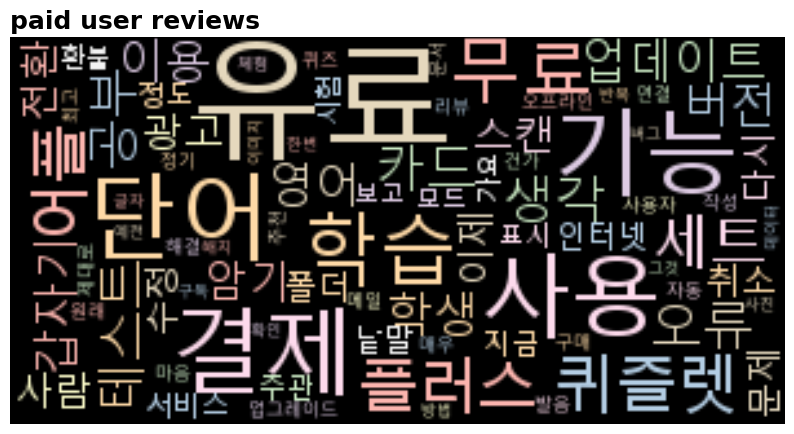

In [8]:
get_WordCloud(result_df, "paid user reviews")